In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [3]:
def get_theta(eta):
    return 2*np.arctan(np.exp(-eta))

In [4]:
class BeamSetting():
    def __init__(self, Ebeam, Pbeam):
        self.Ebeam=Ebeam
        self.Pbeam=Pbeam


In [5]:
beam_settings=[BeamSetting(e,p) for (e,p) in [(18, 275), (10,275), (10, 100), (5, 100), (5, 41)]]

In [6]:
z=-315
clearance=2

beampipe_diameter=8.9
max_theta=np.pi-np.arctan((beampipe_diameter/2+clearance)/abs(z))

min_eta=-np.log(np.tan(max_theta/2))

print(f"maximum theta: {max_theta*180/np.pi:.2f};  minimum eta: {min_eta:.2f}")

maximum theta: 178.83;  minimum eta: -4.58


In [7]:
def x_Q2(bs, eta, E, thcross=0, phi=0):
    theta=get_theta(eta)
    Q2=4*E*bs.Ebeam*np.sin((np.pi-theta)/2)**2
    
    #angle between P and E is ()
    
    denom = 2*bs.Pbeam*(bs.Ebeam*(1+np.cos(thcross))+E*(np.cos(theta)-1))
    x=Q2/denom
    return x,Q2
    

In [8]:
# 4*Eb*E*sin(coth/2)^2/(2*p*(2*Eb-2*E*sin(th/2)^2))=1
# Eb*E*sin(coth/2)^2=p*(Eb-E*sin(th/2)^2)

# E=p*Eb/((Eb*sin(th/2)^2)

In [9]:
def maxE(bs, eta):
    theta=get_theta(eta)
    return bs.Pbeam*bs.Ebeam/(bs.Pbeam*np.sin(theta/2)**2+bs.Ebeam*np.sin((np.pi-theta)/2)**2)

In [10]:
x_Q2(bs, -6, maxE(bs, -6))

NameError: name 'bs' is not defined

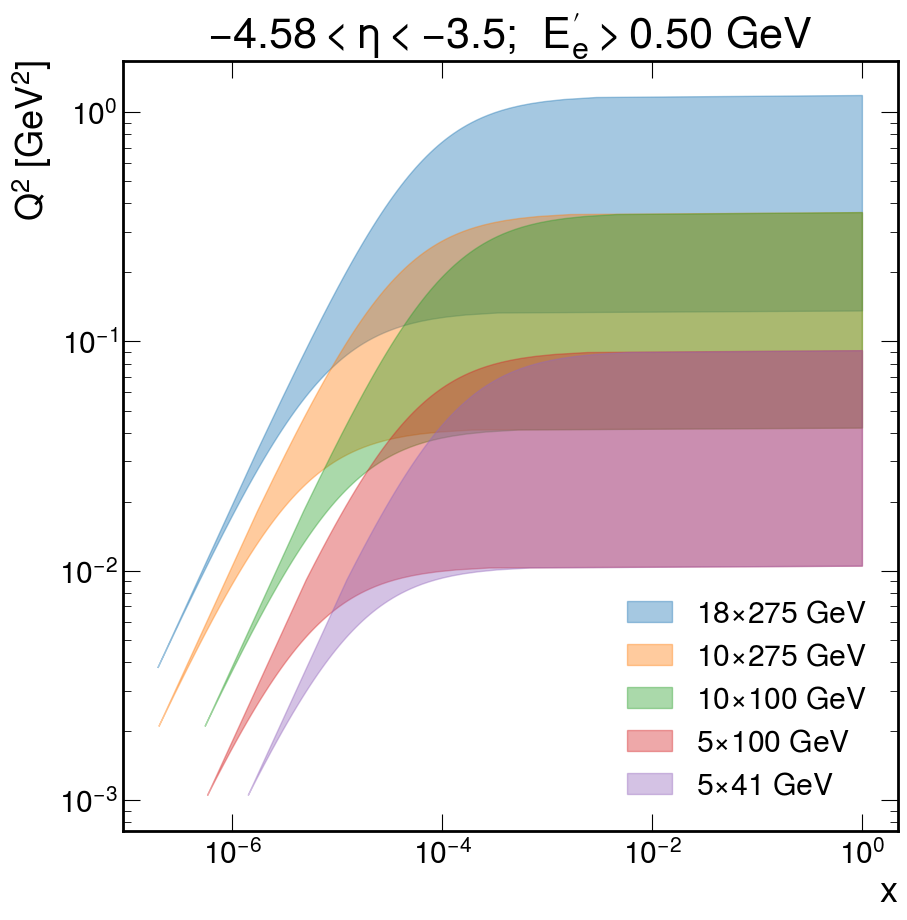

In [11]:
def x_Q2_plot(minE=0.5, mineta=min_eta, maxeta=-3.5):
    colors='tab:blue tab:orange tab:green tab:red tab:purple'.split()
    for i,bs in enumerate(beam_settings):
        E=np.array([])
        eta=np.array([])
        

        N=50

        #Emax=p*Eb/((Eb+p)*sin(th/2)^2)
        s=1
        eta = np.concatenate([eta,np.linspace(mineta, maxeta, N)])
        E = np.concatenate([E, s*maxE(bs,np.linspace(mineta, maxeta, N))])
        eta = np.concatenate([eta,np.linspace(maxeta, maxeta, N)])
        E = np.concatenate([E, np.linspace(s*maxE(bs, maxeta), minE, N)])
        eta = np.concatenate([eta,np.linspace(maxeta, mineta, N)])
        E = np.concatenate([E, np.linspace(minE, minE, N)])
        eta = np.concatenate([eta,np.linspace(mineta, mineta, N)])
        E = np.concatenate([E, np.linspace(minE, s*maxE(bs,mineta), N)])
        vals=x_Q2(bs, eta, E)

        vals=[(vals[0][i],vals[1][i]) for i in range(len(vals[0]))]
        #print(get_theta(eta))
        plt.gca().add_patch(mpl.patches.Polygon(vals, color=colors[i],
                                                label=f'{bs.Ebeam}$\\times${bs.Pbeam} GeV', alpha=0.4))
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("x")
    plt.ylabel("$Q^2$ [GeV$^2$]")
    plt.legend(loc='lower right')
    plt.title(f"${mineta:.2f}<\\eta<{maxeta}$;  $E_e'>{minE:.2f}$ GeV")
    
x_Q2_plot()

In [12]:
gran=0.5
z=-236

print(f"{10*gran} mm at z={z} cm: dtheta={gran/z/np.sqrt(12):.2}")

5.0 mm at z=-236 cm: dtheta=-0.00061


In [13]:
def Q2resfrac(eta, Eresfrac, thetares):
    theta=get_theta(eta)
    return np.hypot(Eresfrac, thetares*np.tan(theta/2))

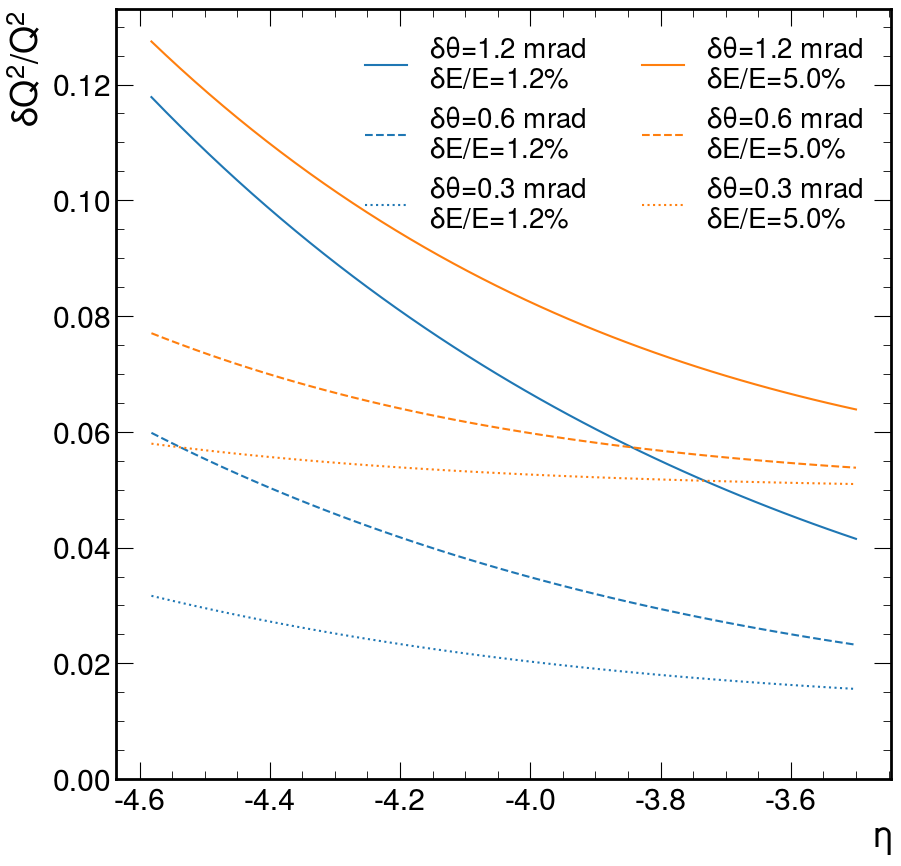

In [16]:

eta=np.linspace(min_eta, -3.5)
linestyles='- -- :'.split()
colors='tab:blue tab:orange tab:green'.split()
for i,Eresfrac in enumerate((0.012, 0.05)):
    for j,thetares in enumerate((0.0012, 0.0006, 0.0003)):
        plt.plot(eta, Q2resfrac(eta, Eresfrac, thetares), 
                 label=f'$\delta\\theta$={1000*thetares:.1f} mrad\n$\delta E/E$={100*Eresfrac:.1f}%',
                color=colors[i], ls=linestyles[j])
    plt.text(-3.75, Eresfrac-.005, f"", fontsize=20)
        
plt.ylim(0)
plt.xlabel('$\\eta$')
plt.ylabel('$\\delta Q^2/Q^2$')
plt.legend(ncol=2, fontsize=20)
plt.show()

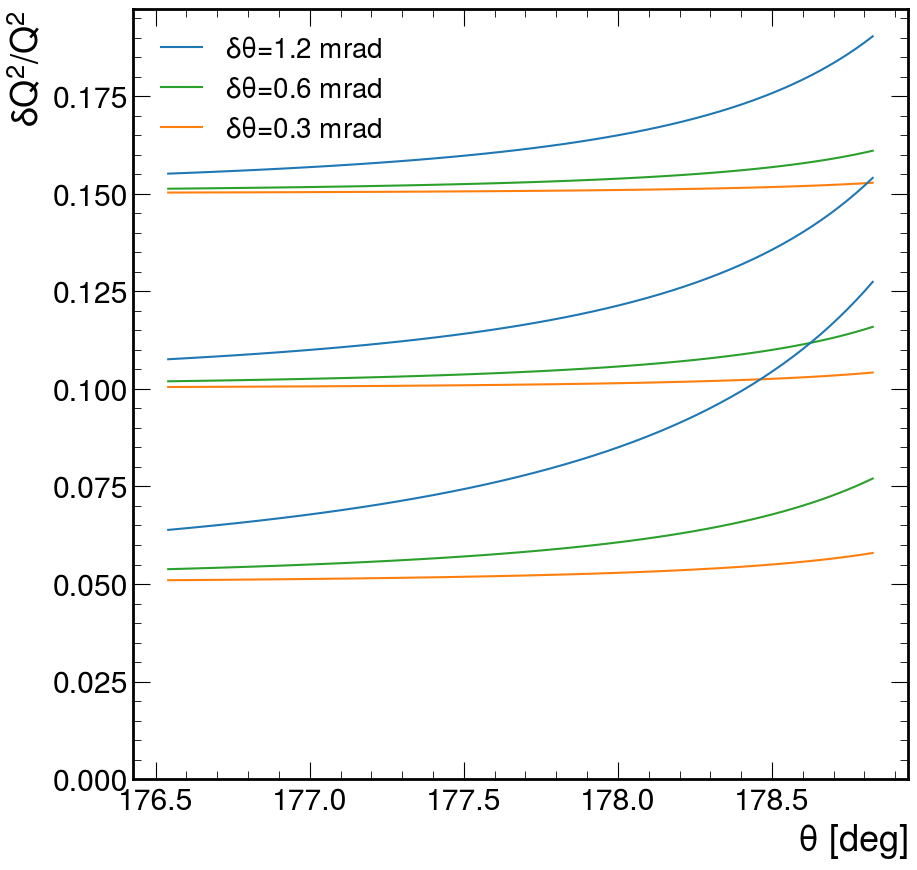

In [17]:
eta=np.linspace(min_eta, -3.5)
for i,Eresfrac in enumerate((0.15, 0.10, 0.05)):
    colors='tab:blue tab:green tab:orange'.split()
    for j,thetares in enumerate((0.0012, 0.0006, 0.0003)):
        plt.plot(get_theta(eta)*180/np.pi, Q2resfrac(eta, Eresfrac, thetares), 
                 label=f'$\delta\\theta$={1000*thetares:.1f} mrad' if i == 0 else None,
                color=colors[j])
    #plt.text(-170, Eresfrac-.005, f"$\delta E/E$={100*Eresfrac:.0f}%", fontsize=20)
        
plt.ylim(0)
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\delta Q^2/Q^2$')
plt.legend(ncol=1, fontsize=20)


plt.show()